# **Customer Classification for Bank Marketing Campaign - Part 3** 🏢


**Table of content :**

0. Initial Setup
1. Data Preparation - Handling Problems & Feature Engineering
2. Modeling Experiment
3. Conclusion and Recommendation

****

## **Initial Setup**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np

from imblearn.over_sampling import *
from imblearn.under_sampling import *

from pycaret.classification import *
from pycaret.internal.preprocess.transformers import TransformerWrapper, FixImbalancer

from category_encoders import OneHotEncoder, BinaryEncoder, OrdinalEncoder
from typing import Literal

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector

from scipy.stats.mstats import winsorize

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 21
K_FOLDS = 10


In [2]:
# import dataset                                                                        
df = pd.read_csv('new_data.csv')
display(df.head(), df.tail())

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,marital,education,default,day,duration,previous
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes,married,secondary,no,4,94,0
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,married,tertiary,no,17,882,0
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,married,secondary,no,7,476,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,single,primary,no,13,531,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,married,secondary,no,18,176,0


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,marital,education,default,day,duration,previous
7813,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes,married,secondary,no,3,322,0
7814,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes,married,tertiary,no,24,127,2
7815,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no,married,secondary,no,8,14,0
7816,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no,married,secondary,no,21,226,0
7817,60,retired,1588,no,no,cellular,oct,1,-1,unknown,yes,married,primary,no,6,728,0


In [3]:
# check df shape
df.shape

(7818, 17)

## **Data Preparation**

### **Create Class for Handling Problems**
Handling problems in the dataset is done by creating a class that contains all the handling functions, which will later be integrated into a pipeline along with feature engineering and used in the experimental setup.

Within the class, there are functions to handle issues in both numerical and categorical columns. For numerical columns, outlier handling is performed. Meanwhile, for categorical columns, handling of unknown values, cardinality, and also converting ordinal category values into numbers is carried out to prepare for the encoding stage.

In [4]:
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # HANDLING OUTLIERS IN NUMERICAL COLUMNS
        # --------------------------------------
        # handling ouliers in balance column
        X['balance'] = winsorize(X['balance'], limits=(0.05, 0.05))
        X['duration'] = winsorize(X['duration'], limits=(0.05, 0.05))
        X['previous'] = winsorize(X['previous'], limits=(0.05, 0.05))

        # handling outliers in pdays column
        pdays_bins = [-2, -1, 90, 180, 270, 360, np.inf]
        pdays_labels = ['no prior contact', '0-3 months', '3-6 months', '6-9 months', '9-12 months', 'over a year']
        X['pdays'] = pd.cut(X['pdays'], bins=pdays_bins, labels=pdays_labels, right=False)

        # handling outliers in age column
        age_bins = [0, 14, 24, 54, 64, np.inf]
        age_labels = ['children', 'early working age', 'prime working age', 'mature working age', 'elderly']
        X['age'] = pd.cut(X['age'], bins=age_bins, labels=age_labels, right=False)

        # handling outliers in campaign column
        equal_freq = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy='quantile')
        equal_freq.set_output(transform='pandas')
        equal_freq.fit(X[['campaign']])
        # X['campaign'] = pd.qcut(X['campaign'], q=4, labels=['low frequency', 'medium frequency', 'high frequency', 'very high frequency'])

        # HANDLE PROBLEMS IN CATEGORICAL COLUMNS
        # ---------------------------------------

        # reduce cardinality and handle unknown in 'job' column
        X['job'].replace({"entrepreneur" : "self-employed",
                          "student": "unemployed",
                          "retired": "unemployed",   
                          "unknown" : "unemployed",
                          "housemaid": "services"},
                          inplace= True)
        
        # replace value month
        X['month'].replace({"jan": 1,
                            "feb": 2,
                            "mar": 3,
                            "apr": 4,
                            "may": 5,
                            "jun": 6,
                            "jul": 7,
                            "aug": 8,
                            "sep": 9,
                            "oct": 10,
                            "nov": 11,
                            "dec": 12},inplace= True)
        
        # replace value for ordinal encoding
        X['poutcome'].replace({'unknown': 0, 
                               'other': 1, 
                               'failure': 2, 
                               'success': 3}, inplace = True)
        
        # replace value for ordinal encoding
        X['education'].replace({'unknown': 0, 
                               'primary': 1, 
                               'secondary': 2, 
                               'tertiary': 3}, inplace = True)

        return X.to_numpy()

### **Feature Engineering**

The first step in feature engineering is to split the data into the training set and the test set. The "yes" or "no" values in the target variable will be converted into 0 and 1 (encoding) to facilitate the modeling process.

In [5]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_seen, df_unseen = train_test_split(df, stratify=df['deposit'], test_size=0.2, random_state=RANDOM_SEED)
df_seen.shape, df_unseen.shape

((6254, 17), (1564, 17))

Next, a pipeline is created based on the preprocessing steps. The first step is to handle problems in the data, followed by scaling for numerical features, and finally, encoding for categorical features.

In [6]:
# create pipeline

preprocessor = [
    ('cleaning', TransformerWrapper(include=['balance', 'duration', 'previous', 'pdays', 'age', 'campaign', 'job', 'month', 'poutcome', 'education'], transformer=Cleaning())), 
    ('scaling', TransformerWrapper(include=['balance', 'duration', 'previous'], transformer=RobustScaler())),
    ('onehot', TransformerWrapper(include=['job', 'contact', 'marital'], transformer=OneHotEncoder())),
    ('binary', TransformerWrapper(include=['housing', 'loan', 'default'], transformer=BinaryEncoder())),
    ('ordinal', TransformerWrapper(include=['month', 'poutcome', 'pdays', 'age', 'campaign', 'education'], transformer=OrdinalEncoder())) 
]

## **Modeling Experiment**

### **Setup Experiment**

Before conducting modeling experiments, a global experiment setup is carried out which is useful for preparing the environment and also preparing data for modeling. In the setup, we set the parameters that we want to use in conducting experiments.

In [7]:

# General experiment setup
exp = setup(
    # Global config
    experiment_name='Deposit Classification',
    data=df_seen, 
    target='deposit', 
    train_size=0.8,
    verbose=True,

    # Data preprocessing config
    preprocess=False,
    session_id=RANDOM_SEED, 
    custom_pipeline=preprocessor,
    custom_pipeline_position=-1,

    # Model selection config
    fold=K_FOLDS,
    fold_shuffle=False,
    fold_strategy='stratifiedkfold',
)

,Description,Value
0,Session id,21
1,Target,deposit
2,Target type,Binary
3,Original data shape,"(6254, 17)"
4,Transformed data shape,"(6254, 30)"
5,Transformed train set shape,"(5003, 30)"
6,Transformed test set shape,"(1251, 30)"
7,Numeric features,7
8,Categorical features,9


In [8]:
# Show the pipeline
get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\LENOVO\AppData\Local\Temp\joblib),
         steps=[('cleaning',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['balance',
                                                                            'duration',
                                                                            'previous',
                                                                            'pdays',
                                                                            'age',
                                                                            'campaign',
                                                                            'job',
                                                                            'month',
                                                                            'poutcome',
                                                                            'education'],
                                                                   transformer=Cleaning()))),
                ('scaling',
                 TransformerWrapper(exc...
                                                                                                       {'col': 'campaign',
                                                                                                        'data_type': dtype('O'),
                                                                                                        'mapping': 1.0      1
3.0      2
6.0      3
8.0      4
4.0      5
5.0      6
2.0      7
9.0      8
16.0     9
7.0     10
14.0    11
26.0    12
17.0    13
11.0    14
12.0    15
33.0    16
10.0    17
22.0    18
18.0    19
13.0    20
29.0    21
24.0    22
23.0    23
15.0    24
30.0    25
19.0    26
21.0    27
25.0    28
20.0    29
43.0    30
NaN     -2
dtype: int64},
                                                                                                       {'col': 'education',
                                                                                                        'data_type': dtype('O'),
                                                                                                        'mapping': 3.0    1
0.0    2
1.0    3
2.0    4
NaN   -2
dtype: int64}],
                                                                                              return_df=True,
                                                                                              verbose=0))))],
         verbose=False)

In [9]:
# cek hasil transformasi yang dilakukan dari preprocessing 
get_config('X_train_transformed')

,age,job_1,job_2,job_3,job_4,job_5,job_6,job_7,balance,housing_0,...,poutcome,marital_1,marital_2,marital_3,education,default_0,default_1,day,duration,previous
6590,1,1,0,0,0,0,0,0,-0.182345,0,...,1,1,0,0,1,0,1,29,0.039271,0.0
796,2,0,1,0,0,0,0,0,2.862758,1,...,2,0,1,0,2,0,1,28,0.423562,1.0
952,3,0,0,1,0,0,0,0,-0.348582,1,...,1,0,0,1,3,0,1,9,-0.507714,0.0
267,1,0,0,0,1,0,0,0,0.318299,0,...,1,0,1,0,4,0,1,5,-0.081346,0.0
347,3,0,0,0,0,1,0,0,-0.230670,1,...,3,0,0,1,4,0,1,23,0.081346,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6294,3,0,0,0,0,1,0,0,-0.326675,1,...,1,0,0,1,1,0,1,28,-0.566620,0.0
2154,2,0,0,0,1,0,0,0,-0.320232,1,...,4,0,1,0,1,0,1,18,2.336606,2.0
5124,3,0,0,0,0,1,0,0,3.619201,1,...,2,0,0,1,2,0,1,10,-0.182328,1.0
167,3,0,0,1,0,0,0,0,0.054124,0,...,1,0,1,0,4,0,1,30,-0.215989,0.0


### **Define Metric Business-Score**

In this project, we will also use business metrics in the form of profit. As an illustration of these business metrics, we will try to use confusion metrics obtained from the classification results of the machine learning model that was previously created to make a calculation simulation.

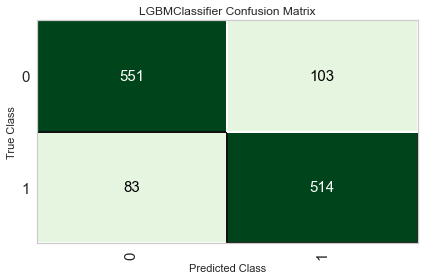

| Description      | Customer| $Value      | Total|
|-----------------|------------|----------------|----------------|
| True Positive | 514 | EUR 257 | EUR 132.098 |
| True Positive + False Positive | 617 | -EUR 33.2 |-EUR 20.484,4|
||||**EUR 111.613,6**|

From here we will calculate the profit and add the metric to PyCaret.

In [10]:
# create a custom function
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (257-33), 0)
    fp = np.where((y_pred==1) & (y==0), -33, 0)
    return np.sum([tp,fp])

# add metric to PyCaret
add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

### **Benchmark Model**

The first modeling stage is to find a benchmark model to serve as a performance baseline for modeling in the next stage. Given the imbalance in the target, at this stage several experiments will be carried out, namely without using resampling, using resampling overfitting and using resampling underfitting. The results of each experiment will be compared to find the model with the best performance.

#### **Benchmark Model without Resampling**

In [11]:
best_model = compare_models(sort='Profit')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:14:02
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8601,0.9232,0.8794,0.8361,0.8572,0.7202,0.7212,45680.4000,0.2640
rf,Random Forest Classifier,0.8377,0.9101,0.8618,0.8106,0.8353,0.6756,0.6772,44508.6000,0.2230
gbc,Gradient Boosting Classifier,0.8419,0.9175,0.8601,0.8185,0.8387,0.6839,0.6849,44501.5000,0.3190
et,Extra Trees Classifier,0.8221,0.8960,0.8321,0.8027,0.8170,0.6441,0.6447,42895.1000,0.2480
ada,Ada Boost Classifier,0.8245,0.9007,0.8074,0.8218,0.8145,0.6480,0.6482,41807.8000,0.2140
svm,SVM - Linear Kernel,0.7384,0.0000,0.8156,0.7194,0.7504,0.4812,0.5093,40767.5000,0.0780
nb,Naive Bayes,0.7210,0.7992,0.8166,0.6708,0.7365,0.4461,0.4560,40518.6000,0.0710
lr,Logistic Regression,0.8013,0.8793,0.7772,0.8012,0.7886,0.6013,0.6021,40049.8000,0.6160
ridge,Ridge Classifier,0.7991,0.0000,0.7580,0.8097,0.7824,0.5963,0.5980,39134.9000,0.0600
lda,Linear Discriminant Analysis,0.7991,0.8788,0.7580,0.8097,0.7824,0.5963,0.5980,39134.9000,0.0840


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

**Insight :**
- From the benchmark models above, we found that the top three models based on profit are Light Gradient Boosting Machine (lightgbm), Gradient Boosting Classifier (gbc), and Random Forest Classifier (rf).
- In addition to the three top-performing models, we also took other algorithms to increase the variety in the experiments. The models taken from the ensemble boosting category are lightgbm and gbc, ensemble bagging is random forest, and standalone taken are Naive Bayes (nb) and Logistic Regression (lr).

#### **Benchmark Model with Over Sampling Method**
The oversampling methods used in this modeling are SMOTE and Random Over Sampling. From each method, three models with the best performance will be taken. 

Since this experiment will require a different process from the global experiment setup, we will create a new experiment setup as follows:

##### **Experiment Setup**

In [12]:
# SETUP EXPERIMENT FOR SMOTE METHOD
# ---------------------------------
preprocessor_smote = preprocessor.copy()
preprocessor_smote.append(
    ('smote', TransformerWrapper(exclude=None, include=None,
                   transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                             n_jobs=None,
                                                             random_state=None,
                                                             sampling_strategy='auto'))))
)

exp_smote = ClassificationExperiment()
exp_smote.setup(data=df_seen, 
                target='deposit',
                train_size=0.8,
                verbose=False,
                preprocess=False,
                session_id=RANDOM_SEED, 
                fold=K_FOLDS,
                fold_shuffle=False,
                fold_strategy= 'stratifiedkfold',
                custom_pipeline=preprocessor_smote,
                custom_pipeline_position=0
)

# ADD PROFIT METRICS TO SMOTE EXPERIMENT SETUP
# --------------------------------------------
exp_smote.add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [13]:
# SETUP EXPERIMENT FOR RANDOM OVER SAMPLING METHOD
# ---------------------------------

preprocessor_ros = preprocessor.copy()
preprocessor_ros.append(
    ('ros', TransformerWrapper(exclude=None, include=None,
                   transformer=FixImbalancer(estimator=RandomOverSampler(random_state=None,
                                                                         sampling_strategy='auto',
                                                                         shrinkage=None))))
)

exp_ros = ClassificationExperiment()
exp_ros.setup(data=df_seen, 
                target='deposit',
                train_size=0.8,
                verbose=False,
                
                preprocess=False,
                session_id=RANDOM_SEED, 
                fold=K_FOLDS,
                fold_shuffle=False,
                fold_strategy= 'stratifiedkfold',
                custom_pipeline=preprocessor_ros,
                custom_pipeline_position=0
)

# ADD PROFIT METRICS TO ROS EXPERIMENT SETUP
# --------------------------------------------
exp_ros.add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

##### **Compare Models**

After the experimental setup, a comparison of the model with the SMOTE and Random Over Sampling methods was conducted.

- **SMOTE**

In [14]:
exp_smote.compare_models(include=['lr', 'rf', 'lightgbm', 'gbc', 'nb'], sort='profit')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:14:34
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8599,0.9212,0.8857,0.8319,0.8579,0.7200,0.7215,45963.6000,0.2140
gbc,Gradient Boosting Classifier,0.8401,0.9178,0.8702,0.8097,0.8387,0.6806,0.6826,44930.2000,0.2960
rf,Random Forest Classifier,0.8403,0.9100,0.8689,0.8104,0.8385,0.6809,0.6828,44876.2000,0.2260
nb,Naive Bayes,0.7188,0.7978,0.8195,0.6675,0.7356,0.4419,0.4527,40616.0000,0.0950
lr,Logistic Regression,0.8029,0.8794,0.7835,0.8000,0.7912,0.6047,0.6053,40362.7000,0.1830


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

**Insight :**
- From the benchmark model above, the top three models based on profit are Light Gradient Boosting Machine (lightgbm), Random Forest Classifier (rf), and Gradient Boosting Classifier (gbc).
- The business metrics of lightgbm is 45921.4 with an AUC value of 0.9215.

- **Random Over Sampling**

In [15]:
exp_ros.compare_models(include=['lr', 'rf', 'lightgbm', 'gbc', 'nb'], sort='Profit')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:14:46
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8591,0.9232,0.8857,0.8306,0.8571,0.7184,0.7201,45950.4000,0.1920
gbc,Gradient Boosting Classifier,0.8437,0.9177,0.8752,0.8124,0.8425,0.6878,0.6900,45218.8000,0.3210
rf,Random Forest Classifier,0.8381,0.9105,0.8639,0.8102,0.8360,0.6765,0.6782,44610.7000,0.2260
nb,Naive Bayes,0.7226,0.7997,0.8233,0.6708,0.7391,0.4495,0.4604,40850.6000,0.0850
lr,Logistic Regression,0.8027,0.8796,0.7932,0.7938,0.7931,0.6046,0.6052,40798.7000,0.1140


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

**Insight :**
- From the benchmark model above, it is found that the top three models based on profit and AUC are Light Gradient Boosting Machine (lightgbm), Random Forest Classifier (rf), and Gradient Boosting Classifier (gbc).
- Lightgbm as the highest model obtained a profit of 46129 and an AUC value of 0.9233.

#### **Benchmark Model with Under Sampling**

The process that will be done with the under sampling method is similar to what has been done in the previous method. The undersampling methods we will use are NearMiss and Random Under Sampling.

##### **Experiment Setup**

In [16]:
# SETUP EXPERIMENT FOR NEARMISS METHOD
# ---------------------------------
preprocessor_nearmiss = preprocessor.copy()
preprocessor_nearmiss.append(
    (TransformerWrapper(exclude=None, include=None,
                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                n_neighbors=3,
                                                                n_neighbors_ver3=3,
                                                                sampling_strategy='auto',
                                                                version=1)))))

exp_nearmiss = ClassificationExperiment()
exp_nearmiss.setup(data=df_seen, 
                target='deposit',
                train_size=0.8,
                verbose=False,
                
                preprocess=False,
                session_id=RANDOM_SEED, 
                fold=K_FOLDS,
                fold_shuffle=False,
                fold_strategy= 'stratifiedkfold',
                custom_pipeline=preprocessor_nearmiss,
                custom_pipeline_position=0,
)

# ADD PROFIT METRICS TO NEARMISS EXPERIMENT SETUP
# --------------------------------------------
exp_nearmiss.add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [17]:
# SETUP EXPERIMENT FOR RANDOM UNDER SAMPLING METHOD
# ---------------------------------

preprocessor_rus = preprocessor.copy()
preprocessor_rus.append(
    ('ros', TransformerWrapper(exclude=None, include=None,
                   transformer=FixImbalancer(estimator=RandomOverSampler(random_state=None,
                                                                         sampling_strategy='auto',
                                                                         shrinkage=None))))
)

exp_rus = ClassificationExperiment()
exp_rus.setup(data=df_seen, 
                target='deposit',
                train_size=0.8,
                verbose=False,
                
                preprocess=False,
                session_id=RANDOM_SEED, 
                fold=K_FOLDS,
                fold_shuffle=False,
                fold_strategy= 'stratifiedkfold',
                custom_pipeline=preprocessor_ros,
                custom_pipeline_position=0
)

# ADD PROFIT METRICS TO RUS EXPERIMENT SETUP
# --------------------------------------------
exp_rus.add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

#### **Compare Models**

After the experimental setup, a comparison between models with the NearMiss and Random Under Sampling methods was conducted.

- **NearMiss**

In [18]:
exp_nearmiss.compare_models(include=['lr', 'rf', 'lightgbm', 'gbc', 'nb'], sort='profit')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:15:01
Status,. . . . . . . . . . . . . . . . . .,Initializing CV
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8589,0.9208,0.8882,0.8288,0.8573,0.7181,0.7200,46061.7000,0.2030
rf,Random Forest Classifier,0.8385,0.9069,0.8735,0.8052,0.8378,0.6775,0.6800,45056.6000,0.2540
gbc,Gradient Boosting Classifier,0.8391,0.9167,0.8668,0.8100,0.8373,0.6785,0.6803,44760.9000,0.3170
lr,Logistic Regression,0.7999,0.8771,0.7919,0.7899,0.7906,0.5991,0.5995,40695.2000,0.1300
nb,Naive Bayes,0.7154,0.7825,0.7952,0.6705,0.7274,0.4342,0.4414,39452.1000,0.1050


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

**Insight:**
- After handling imbalance using nearmiss and comparison, we found that the highest performing model in terms of profit is with LightGBM, Random Forest, and Gradient Boosting Classifier (gbc).
- We will take two ensemble models and one standalone model to compare in the next step. The ensemble models are LightGBM and Random Forest, while the standalone model is Logistic Regression.

- **Random Under Sampling**

In [19]:
exp_rus.compare_models(include=['lr', 'rf', 'lightgbm', 'gbc', 'nb'], sort='Profit')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:15:12
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8581,0.9222,0.8865,0.8285,0.8564,0.7165,0.7183,45972.1000,0.2740
rf,Random Forest Classifier,0.8427,0.9118,0.8723,0.8125,0.8412,0.6858,0.6877,45068.6000,0.2650
gbc,Gradient Boosting Classifier,0.8419,0.9179,0.8714,0.8117,0.8404,0.6842,0.6860,45017.2000,0.3770
nb,Naive Bayes,0.7210,0.7992,0.8262,0.6683,0.7388,0.4465,0.4583,40957.9000,0.0930
lr,Logistic Regression,0.8033,0.8794,0.7948,0.7940,0.7939,0.6058,0.6065,40885.0000,0.1020


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

**Insight:**
- After handling imbalance using nearmiss and comparison, we found that the highest performing model in terms of profit is LightGBM, Random Forest, and Gradient Boosting Classifier (gbc).
- We will take two ensemble models and one standalone model to compare in the next step. The ensemble models are LightGBM and Random Forest, while the standalone model is Logistic Regression.

#### **Model Comparison**

After obtaining the three best models from each of the resampling and non-resampling methods, we will conduct another comparison to obtain the three best models.

- **Without Resampling**

In [20]:
compare_models(include=['lr', 'rf', 'lightgbm'], sort='Profit', verbose=False)
base_model = pull()

- **With Resampling**

In [21]:
exp_smote.compare_models(include=['lr', 'rf', 'lightgbm'], sort='Profit', verbose=False, n_select=3)
exp_ros.compare_models(include=['lr', 'rf', 'lightgbm'], sort='profit', verbose=False)
exp_nearmiss.compare_models(include=['lr', 'rf', 'lightgbm'], sort='Profit', verbose=False)
exp_rus.compare_models(include=['lr', 'rf', 'lightgbm'], sort='Profit', verbose=False)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [22]:

def create_separator(title, num_columns):
    separator_row = [title] + ['-----'] * (num_columns - 1)  
    return pd.DataFrame([separator_row], columns=base_model.columns) 

num_columns = len(base_model.columns) 

# Creating separator rows
separator_without_resampling = create_separator('Without Resampling', num_columns)
separator_smote = create_separator('Model With SMOTE', num_columns)
separator_ros = create_separator('Model With Random Over Sampling', num_columns)
separator_nearmiss = create_separator('Model With Nearmiss', num_columns)
separator_rus = create_separator('Model With Random Under Sampling', num_columns)

# Concatenating DataFrames with separator rows
compare = pd.concat(
    [   separator_without_resampling, base_model,
        separator_smote, exp_smote.pull().loc[:],
        separator_ros, exp_ros.pull().loc[:],
        separator_nearmiss, exp_nearmiss.pull().loc[:],
        separator_rus, exp_rus.pull().loc[:]
    ], axis=0, ignore_index=True
)
compare

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
0,Without Resampling,-----,-----,-----,-----,-----,-----,-----,-----,-----
1,Light Gradient Boosting Machine,0.8601,0.9232,0.8794,0.8361,0.8572,0.7202,0.7212,45680.4,0.259
2,Random Forest Classifier,0.8377,0.9101,0.8618,0.8106,0.8353,0.6756,0.6772,44508.6,0.215
3,Logistic Regression,0.8013,0.8793,0.7772,0.8012,0.7886,0.6013,0.6021,40049.8,0.088
4,Model With SMOTE,-----,-----,-----,-----,-----,-----,-----,-----,-----
5,Light Gradient Boosting Machine,0.8589,0.9221,0.8836,0.8316,0.8567,0.718,0.7194,45851.6,0.254
6,Random Forest Classifier,0.8393,0.9107,0.8643,0.8116,0.837,0.6789,0.6804,44649.6,0.269
7,Logistic Regression,0.8037,0.8794,0.7848,0.8006,0.7921,0.6063,0.6069,40433.2,0.181
8,Model With Random Over Sampling,-----,-----,-----,-----,-----,-----,-----,-----,-----
9,Light Gradient Boosting Machine,0.8603,0.921,0.8886,0.8308,0.8586,0.7208,0.7226,46103.9,0.259


**Insight:**
- From the comparison of the above 15 models, it is found that the best performing models based on profit metrics are as follows: 
    - lightgbm with random over sampling
    - random forest nearmiss
    - logistic regression with undersampling

### **Cross Validation & Hyperparameter Tuning**

In this stage, we will perform cross validation and tuning on each of the selected models. Each model will be cross validated. Then the cross validation results will be compared with the model performance after cross validation and tuning.

- #### **LightGBM Model**

In [75]:
lightgbm_ros = exp_ros.create_model('lightgbm', fold=K_FOLDS, cross_validation=True, return_train_score=True, verbose=False )
lightgbm_table = exp_ros.pull()

In [83]:

lightgbm_grid = {
    'num_leaves': [15, 30, 50],
    'max_depth': [3, 5, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'n_estimators': [10, 50, 70, 90],
    'reg_alpha': [ 0.1, 1, 10, 100],
    'reg_lambda': [0.1, 1, 10, 100]
 }


In [84]:
tuned_lgbm = exp_ros.tune_model(
    fold=K_FOLDS,
    estimator=lightgbm_ros, 
    optimize='Profit', 
    n_iter=20, 
    custom_grid=lightgbm_grid, 
    search_library='scikit-learn',
    search_algorithm='random',
    return_train_score=True, 
    verbose=False
)

tuned_lgbm_table = exp_ros.pull()

- **Before Tuning**

In [85]:
lightgbm_table.iloc[-5:-1]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.9405  0.9896  0.9689  0.9120  0.9396  0.8812  0.8827   
         Std     0.0016  0.0006  0.0025  0.0024  0.0017  0.0033  0.0033   
CV-Val   Mean    0.8605  0.9232  0.8882  0.8313  0.8587  0.7212  0.7229   
         Std     0.0122  0.0114  0.0126  0.0152  0.0117  0.0243  0.0241   

                    Profit  
Split    Fold               
CV-Train Mean  459827.9000  
         Std     1164.0539  
CV-Val   Mean   46088.1000  
         Std      670.8381

- **After Tuning**

In [86]:
tuned_lgbm_table.iloc[-5:-1]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.8663  0.9387  0.9064  0.8294  0.8662  0.7332  0.7361   
         Std     0.0025  0.0012  0.0034  0.0028  0.0025  0.0050  0.0051   
CV-Val   Mean    0.8467  0.9186  0.8819  0.8133  0.8460  0.6939  0.6965   
         Std     0.0135  0.0126  0.0168  0.0194  0.0126  0.0268  0.0264   

                    Profit  
Split    Fold               
CV-Train Mean  423132.2000  
         Std     1630.1028  
CV-Val   Mean   45573.9000  
         Std      835.8378

**Insight:**
- There was a decrease in profit before and after tuning on both train and validation data. 
- The decrease in AUC value occurs in train data and validation data. Previously the train data was worth 0.986 to 0.9387. In validation data, there was also a decrease in AUC value from 0.9232 to 0.9186. 
- The performance of the lgbm model on profit and AUC is better in conditions before hyperparameter tuning.


- #### **Random Forest Model**

In [44]:
rf_nearmiss = exp_nearmiss.create_model('rf', cross_validation=True, fold=10, return_train_score=True, verbose=False)
rf_table = exp_nearmiss.pull()

In [45]:

rf_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [46]:
tuned_rf = exp_nearmiss.tune_model(
    fold=K_FOLDS,
    estimator=rf_nearmiss, 
    optimize='Profit', 
    n_iter=20, 
    custom_grid=rf_grid, 
    search_library='scikit-learn',
    search_algorithm='random',
    return_train_score=True, 
    verbose=False
)
tuned_rf_table =exp_nearmiss.pull()

- **Before Tuning**

In [47]:
rf_table.iloc[-5:-1]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.9904  0.9983  1.0000  0.9803  0.9901  0.9808  0.9810   
         Std     0.0011  0.0004  0.0000  0.0022  0.0011  0.0022  0.0021   
CV-Val   Mean    0.8385  0.9069  0.8735  0.8052  0.8378  0.6775  0.6800   
         Std     0.0135  0.0089  0.0144  0.0183  0.0125  0.0268  0.0263   

                    Profit  
Split    Fold               
CV-Train Mean  479995.2000  
         Std      164.6273  
CV-Val   Mean   45056.6000  
         Std      742.7402

- **After Tuning**

In [48]:
tuned_rf_table.iloc[-5:-1]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.9540  0.9926  0.9819  0.9262  0.9533  0.9082  0.9097   
         Std     0.0020  0.0007  0.0014  0.0029  0.0020  0.0039  0.0038   
CV-Val   Mean    0.8435  0.9115  0.8840  0.8070  0.8436  0.6877  0.6908   
         Std     0.0143  0.0088  0.0178  0.0184  0.0136  0.0284  0.0278   

                    Profit  
Split    Fold               
CV-Train Mean  467182.3000  
         Std      833.3411  
CV-Val   Mean   45616.6000  
         Std      914.0282

**Insight:**
- There was a decrease in the profit value on train from 479995.2 to 467182. But in val, there is an increase after tuning from 45056 to 45616.6
- The AUC value on validation data increased after hyperparameter tuning from 0.9069 to 0.9115. The AUC value in training decreased from 0.9983 to 0.9926.
- The difference between train and validation AUC values after tuning decreased to 0.081 from 0.9139 previously.
- By comparing the random forest model before and after tuning, the better model is the random forest model after tuning.

- #### **Logistic Regression Model**

In [49]:
lr_rus = exp_rus.create_model('lr', cross_validation=True, fold=10, return_train_score=True, verbose=False)
lr_table = exp_rus.pull()

In [50]:
lr_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 300, 350]
}

The parameters used in tuning logistic regression are as follows:

* `C` is the inverse of regularization strength. It determines how much you want to regularize the logistic regression model.
* `penalty` or regularization penalty is hyperparameter that specifies the type of regularization to be applied.
* `solver` specifies the algorithm used for optimization during model training. 
* `max_iter` sets the maximum number of iterations (epochs) for the solver to converge to a solution.

In [51]:
tuned_lr = exp_rus.tune_model(
    fold=K_FOLDS,
    estimator=lr_rus, 
    optimize='Profit', 
    n_iter=20, 
    custom_grid=lr_grid, 
    search_library='scikit-learn',
    search_algorithm='random',
    return_train_score=True, 
    verbose=False
)
tuned_lr_table =exp_rus.pull()

- **Before Tuning**

In [52]:
lr_table.iloc[-5:-1]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.8058  0.8820  0.7999  0.7946  0.7972  0.6109  0.6109   
         Std     0.0015  0.0013  0.0030  0.0013  0.0018  0.0031  0.0031   
CV-Val   Mean    0.8023  0.8790  0.7927  0.7935  0.7927  0.6038  0.6044   
         Std     0.0069  0.0103  0.0267  0.0128  0.0099  0.0141  0.0143   

                    Profit  
Split    Fold               
CV-Train Mean  370432.3000  
         Std     1413.5654  
CV-Val   Mean   40773.0000  
         Std     1252.4569

- **After Tuning**

In [53]:
tuned_lr_table.iloc[-5:-1]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.8056  0.8820  0.7998  0.7944  0.7971  0.6106  0.6106   
         Std     0.0014  0.0013  0.0027  0.0012  0.0017  0.0029  0.0029   
CV-Val   Mean    0.8015  0.8790  0.7932  0.7920  0.7921  0.6023  0.6029   
         Std     0.0065  0.0106  0.0276  0.0117  0.0102  0.0135  0.0134   

                    Profit  
Split    Fold               
CV-Train Mean  370351.9000  
         Std     1248.6732  
CV-Val   Mean   40778.9000  
         Std     1297.4861

**Insight:**
- After performing hyperparameter tuning, there is a decrease in AUC in the train data from 0.8820 to 0.8819. For validation data, the AUC decreased from 0.8793 to 0.8792. 
- The decrease after tuning also occurred in the profit value where in the train before tuning the value was 370432, while after tuning it was 370351. But in val, there is a slight increase from before and after tuning, namely from 40773 to 40779. 
- By comparing the logistic regression model before and after tuning, the better performance is in logistic regression after tuning.

### **Model Selection & Model Evaluation**


#### **Model Selection**

After tuning the hyperparameters and comparing the performance before and after tuning, the next step is to select the best model to be implemented as the final model.

In [88]:
compare_models(include=[ tuned_lr, lightgbm_ros, tuned_rf])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:03:46
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
1,Light Gradient Boosting Machine,0.8601,0.9232,0.8794,0.8361,0.8572,0.7202,0.7212,45680.4000,0.2040
2,Random Forest Classifier,0.8423,0.9127,0.8727,0.8117,0.8409,0.6850,0.6871,45081.1000,0.2930
0,Logistic Regression,0.8013,0.8793,0.7772,0.8012,0.7886,0.6013,0.6021,40049.8000,0.5430


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

From the comparison between models, it is found that the Light Gradient Boosting Machine model has higher profit and AUC values than other models. The lightgbm model is then determined as the model to be evaluated and used for finalization.

#### **Model Evaluation**

We will evaluate the performance of the model through the following graphs.

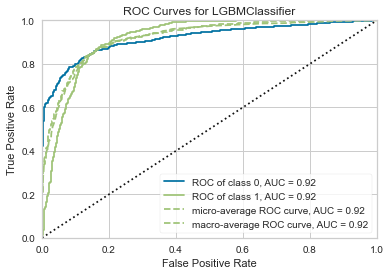

In [90]:
plot_model(lightgbm_ros, plot='auc')

**Insight:**
- The AUC value ranges from 0 to 1 and represents the classifier's ability to discriminate between positive and negative classes. An AUC of 0.92 is considered very good, indicating that the model has a high measure of separability and is capable of distinguishing between the two classes with high accuracy.
- The fact that the AUC for both classes and the micro and macro averages are all 0.92 suggests that the classifier performs equally well for both classes. 

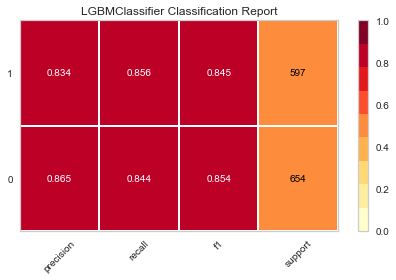

In [94]:
plot_model(lightgbm_ros, plot= 'class_report')

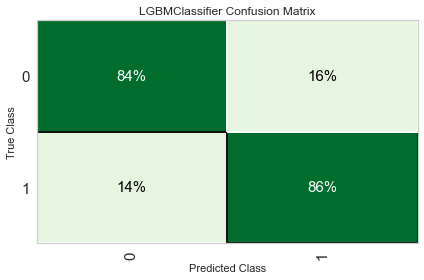

In [92]:
plot_model(lightgbm_ros, plot='confusion_matrix', plot_kwargs={'percent': True})

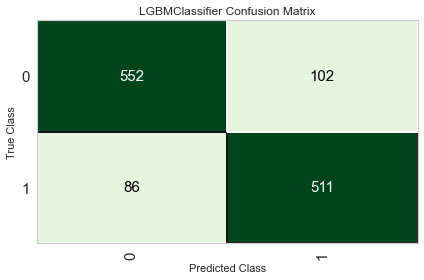

In [93]:
plot_model(lightgbm_ros, plot='confusion_matrix')

**Insight:**
- The f1-score value in the positive class is 0.845 and in the negative class is 0.854. 
- in the positive class recall produces a value of 0.856 and precision produces a value of 0.834. This means that of all 597 positive observations, 85.6% of customers who are predicted positive, factually invest in term-deposits. And of all customers who are predicted to open a deposit (true positive + false positive), which is 613 people, 83%,4 factually open a deposit account. 
- In the negative class, recall produces a value of 0.844 and precision produces a value of 0.865. This shows that of the total negative observations of 654 customers, 84.4% of those predicted to be negative, did not in fact open a term-deposit account. Meanwhile, of all customers who are predicted not to open a deposit (true negative + false negative) as many as 638 people, as many as 86.5% of all customers are predicted to open a term-deposit account.

### **Model Explanation**

#### **Global Explanation**

We will see the contribution of each feature through SHAP (Shapley Additive Explanations). SHAP is an interpretation method used to explain the contribution of each feature in making model predictions on data.

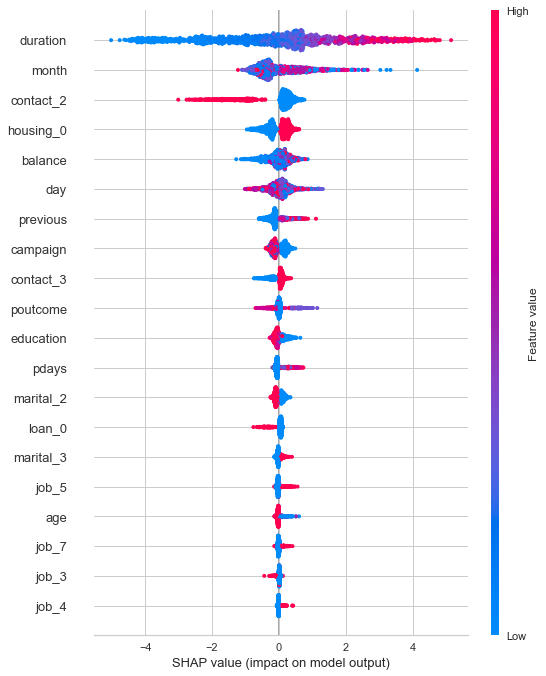

In [95]:
interpret_model(lightgbm_ros, plot = 'summary')

**Insight:**
- From the graph, it can be seen the contribution of each feature to produce a certain output. The 5 most contributing features are duration, month, contact_2, previous, and housing_0.
- The feature that has the greatest contribution value is duration. The longer the duration of the bank contacting the customer affects the prediction of a customer opening a deposit account. 
- The month feature is the second most contributing feature, where from the color and density, customers who are contacted at the beginning of the year (indicated by low values in blue) are predicted not to open a deposit account. 
- From the contact feature, it is known that customers who are contacted by phone tend to open a deposit. 
- of the five features with the largest contribution, the most influential for classifying are features related to campaigns. this shows that marketing efforts contribute greatly to increasing the number of customers who invest in term-deposits.

#### **Model Limitation**

We'll see set of classification metrics calculated for different ranges of predicted probabilities

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predicted_probabilities = lightgbm_ros.predict_proba(get_config('X_test_transformed'))[:, 1]

y_test = get_config('y_test_transformed') 

bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(predicted_probabilities, bins) - 1

results_data = []

for i in range(len(bins) - 1):
    in_bin = bin_indices == i
    actual_in_bin = y_test[in_bin]
    predictions_in_bin = (predicted_probabilities[in_bin] > 0.5).astype(int)

    accuracy = accuracy_score(actual_in_bin, predictions_in_bin)
    precision = precision_score(actual_in_bin, predictions_in_bin, zero_division=0)
    recall = recall_score(actual_in_bin, predictions_in_bin, zero_division=0)
    f1 = f1_score(actual_in_bin, predictions_in_bin, zero_division=0)
    
    range_label = f"{bins[i]*100:.0f}% - {bins[i+1]*100:.0f}%"
    results_data.append({
        'Range Probability': range_label,
        'Accuracy' : accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

results_df = pd.DataFrame(results_data)
results_df

,Range Probability,Accuracy,Precision,Recall,F1 Score
0,0% - 10%,0.982927,0.000000,0.0,0.000000
1,10% - 20%,0.750000,0.000000,0.0,0.000000
2,20% - 30%,0.691176,0.000000,0.0,0.000000
3,30% - 40%,0.555556,0.000000,0.0,0.000000
4,40% - 50%,0.512821,0.000000,0.0,0.000000
5,50% - 60%,0.605263,0.605263,1.0,0.754098
6,60% - 70%,0.679245,0.679245,1.0,0.808989
7,70% - 80%,0.780220,0.780220,1.0,0.876543
8,80% - 90%,0.852941,0.852941,1.0,0.920635
9,90% - 100%,0.904215,0.904215,1.0,0.949698


**Insight:**
- This metric represents the ratio of correct predictions (both true positives and true negatives) to total predictions within each probability range. Notably, the accuracy is high in the 0%-10% range, suggesting that the model is good at identifying negatives in this low-probability range. However, accuracy alone is not reliable when the data is imbalanced or when the cost of false positives is different from the cost of false negatives
- Precision measures the ratio of true positives to all positive predictions (true positives plus false positives). In this table, precision is zero for probability ranges from 0% to 40%, indicating there were either no predictions made as positive or all positive predictions in these ranges were false positives. Precision then improves in higher probability ranges, reaching its peak in the 90%-100% range.
- Recall (also known as sensitivity) measures the ratio of true positives to all actual positives (true positives plus false negatives). It's zero in ranges from 0% to 40%, suggesting that the model fails to identify any actual positives in these ranges. From 50% probability and onwards, recall is 1.0, indicating that the model identifies all actual positives in these ranges.
-  The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. F1 score is zero for the 0%-40% probability ranges due to the zero precision and recall, and then it increases as both precision and recall improve, reaching its highest in the 90%-100% range.
- The model seems to perform poorly in the lower probability ranges, as indicated by low or zero values for precision, recall, and F1 score. Performance improves significantly in the higher probability ranges. This could indicate that the model is conservative, only confidently predicting positives when the probability is high

### **Prediction on Validation Data**

In [99]:
_ = predict_model(lightgbm_ros, verbose=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Light Gradient Boosting Machine,0.8497,0.9178,0.8559,0.8336,0.8446,0.6992,0.6994,111098


### **Finalize Model**

In [100]:
final_model = finalize_model(lightgbm_ros)
plot_model(final_model, plot="parameter")

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [101]:
unseen_predictions = predict_model(final_model, data=df_unseen, raw_score=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Light Gradient Boosting Machine,0.8651,0.9216,0.9170,0.8213,0.8665,0.7310,0.7355,148523


**Insight:**

- The results of the model predictions on validation data and unseen data show that the model performs better on unseen data but still within a close range. 
- This shows the consistency of the model in terms of the ability to classify positive and negative classes.

[LightGBM] [Info] Number of positive: 215, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430000 -> initscore=-0.281851
[LightGBM] [Info] Start training from score -0.281851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

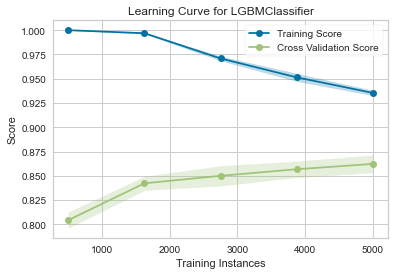

<AxesSubplot:title={'center':'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [102]:
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import roc_auc_score, make_scorer

curve = LearningCurve(final_model, scoring=make_scorer(roc_auc_score))
curve.fit(get_config('X'), get_config('y'))
curve.show()

From the learning curve using the final model, it is found that as the number of training instances increases, the training score decreases and the cross-validation score increases, thus reducing overfitting.

### **Further Analysis**

Here we will compare business calculations with and without using the model to see whether the model can answer business problems or not. Previously, we will classify the model prediction results against unseen data into confusion metrix first.

In [113]:
dff = exp_ros.predict_model(final_model, data=df_unseen, verbose=False)
dff

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,marital,education,default,day,duration,previous,deposit,prediction_label,prediction_score
4674,35,admin.,-32,no,yes,cellular,feb,4,182,failure,single,secondary,no,9,63,5,1,0,0.9898
5321,36,services,38,no,no,unknown,jun,4,-1,unknown,single,primary,no,6,308,0,0,0,0.9875
5809,59,blue-collar,337,no,no,unknown,jun,4,-1,unknown,married,unknown,no,18,100,0,0,0,0.9930
4801,31,management,78,yes,no,cellular,jul,2,-1,unknown,single,tertiary,no,22,369,0,0,0,0.7584
2266,49,blue-collar,0,no,yes,cellular,jul,1,-1,unknown,married,secondary,no,9,625,0,1,1,0.7217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4866,33,admin.,920,no,no,cellular,apr,1,-1,unknown,married,secondary,no,30,344,0,1,1,0.9466
3190,53,retired,0,no,yes,unknown,jun,1,-1,unknown,married,primary,no,27,747,0,0,1,0.8036
187,45,technician,2403,no,no,cellular,nov,1,-1,unknown,married,secondary,no,21,207,0,0,0,0.6811
7139,36,admin.,4708,no,no,cellular,jun,1,-1,unknown,divorced,tertiary,no,15,104,0,0,1,0.7331


In [116]:
true_positif = dff.query("(deposit == 1 & prediction_label == 1)")
false_positif = dff.query("(deposit == 0 & prediction_label == 1)")
true_negatif = dff.query("(deposit == 0 & prediction_label == 0)")
false_negatif = dff.query("(deposit == 1 & prediction_label == 0)")

print(f"TP : {len(true_positif)}")
print(f"FP: {len(false_positif)}")
print(f"TN: {len(true_negatif)}")
print(f"FN: {len(false_negatif)}")
print(f"Total customer in the dataset: {len(dff)}")

TP : 685
FP: 149
TN: 668
FN: 62
Total customer in the dataset: 1564


| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `TP` | 685 |
| `FP` | 149 | 
| `TN` | 668 |
| `FN` | 62 | 

Next, we will compare the profit calculation with and without the model.

----------------

**Comparison of Marketing Expenses With and Without Model**

--------------------
Without the model, the bank contacted all customers, resulting in 1564 x EUR 33.2 = **EUR 51,924.8**. Meanwhile, there were 817 customers who factually did not want to open a deposit account. Therefore, the wasted marketing cost is 817 x EUR 33.2 = EUR 27124.4. 

If using the model, the bank only contacts people who are predicted to open a deposit. Here is the calculation:

| Description      | Customer| $Value      | Total|
|-----------------|------------|----------------|----------------|
| True Positive + False Positive| 834 | EUR 33.2 | EUR 27688.8 |
| False Positive  | 149 | EUR 33.2 |EUR 4946.8|

From this it can be seen that using the marketing cost model is much smaller than the costs that the bank had to incur before. The marketing cost savings that the bank can make are:

**Marketing Savings** = ((initial_cost_marketing - final_cost_marketing) / initial_cost_marketing) * 100 = **46.67%**

Meanwhile, the losses that can be reduced by using the model are 

**Loss Reduction** = ((initial_loss - final_loss) / initial_loss) * 100  = **81.7%**

--------------------

**Comparison of Profit from Deposits with and Without Model**

---------------------

We will calculate the bank's profit from deposits when not using the model. 

**Profit** = Profit from depositing customers - Marketing cost = (685 x EUR 257) - EUR 51924.8 = **EUR 124120.2**

If without the model the bank contacts everyone, then with the model the bank only contacts people who are predicted to be positive. If a false negative occurs, the potential loss to the bank is 
**loss due to false negatives** = total FN x potential profit  = 62 x EUR 257 = EUR 15934

Thus we can calculate the bank's profit when using the following model: 

**Profit** = Profit from depositing customers - Marketing costs - loss due to false negatives  = (685 x EUR 257) - EUR 27688.8 - EUR 15,934 = **EUR 132422.2**

The increase in profit from before using the model is **6.68%.**

From this we can see that the use of the model can help banks to save marketing costs and other resources in campaign efforts so that they can focus on potential targets. 

## **Conclusion & Recommendation**

### **Conclusion**

**Modeling Process**

* From the modeling conducted using 5 experiments consisting of modeling without resampling and with resampling, the best model is Light Gradient Boosting Machine (LightGBM).

* The final performance of the LightGBM model on test data in terms of AUC is 0.9216, and in terms of profit is EUR 148523. This value is up from the previous validation prediction of AUC 0.917 and profit EUR 111098.

* From the importance features, it is found that features related to the campaign effort carried out by the bank such as duration, time and contact occupy the highest level of contribution. Therefore, banks need to pay more attention to the time and contact aspects when conducting campaigns. 

**Model Limitation**
* The model performs well for predicting positive values in the probability range of 70 - 100%. 

* The model accuracy is low in the probability range of 20-70% which is about 0.6911

**Business Impact**
* The model can help banks to save marketing costs by 46.67% and reduce loss on marketing costs by 81.7%.

* The increase in profit that can be obtained by banks using the model is 6.68%

### **Recommendation**

- Data can be completed again, especially if there is additional demographic data so that banks can get a more complete profile of potential customers so that they can predict more accurately. 
- Experiment with different evaluation metrics that are more appropriate for imbalanced datasets, like AUC-ROC, precision-recall curves, F1 score, etc. Especially evaluation metrics that can reduce False Negative. 
- Use methods like grid search, random search, or Bayesian optimization to find the optimal hyperparameters for the model.
- Seek to identify more representative calculations regarding term deposits at banks to provide solutions that are better aligned with customer needs.


## **Save Model**

In [69]:
import pickle

pickle.dump(final_model, open('Bank_Campaign_Classification.sav', 'wb'))
# Load model 
filename = 'Bank_Campaign_Classification.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [147]:
loaded_model

Pipeline(memory=Memory(location=None),
         steps=[('cleaning',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['balance',
                                                                            'duration',
                                                                            'previous',
                                                                            'pdays',
                                                                            'age',
                                                                            'campaign',
                                                                            'job',
                                                                            'month',
                                                                            'poutcome',
                                                                            'education'],
                                                                   transformer=Cleaning()))),
                ('scaling',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=Transf...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None, random_state=21,
                                reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [148]:
with open('Bank_Campaign_Classification.sav', wb)

SyntaxError: expected ':' (2493009879.py, line 1)